In [ ]:
map_scale = 3
p = 0.8
!optuna-dashboard sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}.db

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optuna

In [15]:
def plot_accuracy_evolution(trial, label=""):
    def smooth(x, w=0.01):
        filter = jnp.ones(int(1 + w * len(x)))
        smoothed = jnp.convolve(jnp.array(x), filter / filter.sum(), mode="full")
        return smoothed[: len(x)]

    mean = smooth(trial.user_attrs["accuracy_evol_mean"])
    std = smooth(trial.user_attrs["accuracy_evol_std"])
    upper_bound = smooth(trial.user_attrs["accuracy_evol_max"])
    lower_bound = smooth(trial.user_attrs["accuracy_evol_min"])
    plt.plot(mean, label=label)
    color = plt.gca().lines[-1].get_color()
    # plt.plot(smooth(mean+std), color=color, linestyle="--")
    # plt.plot(smooth(mean-std), color=color, linestyle="--")
    plt.fill_between(range(len(mean)), smooth(upper_bound), smooth(lower_bound), alpha=0.3, color=color)

    stages_duration = [
        trial.user_attrs["cycle_train_iter"] * trial.params[f"train_cycles_{i}"]
        for i in range(len(cell_scales)-1)
    ]
    for stage_duration in jnp.cumsum(jnp.array(stages_duration)):
        plt.axvline(stage_duration, color="red")
    plt.grid()
    plt.ylim(0, 1)

n_trials 64
n_trials 3


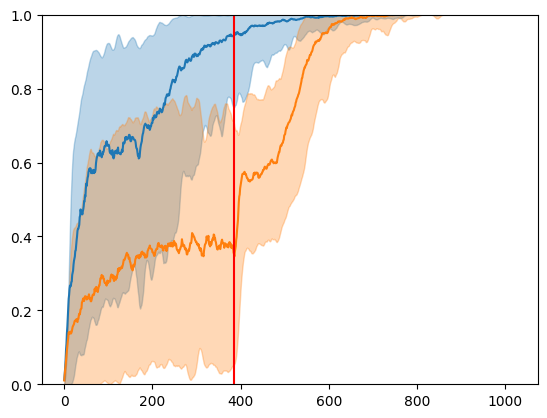

In [16]:
map_scale = 2
p = 0.8

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}.db"
for cell_scales in [(map_scale,), tuple(range(1, map_scale + 1))]:
    study = optuna.load_study(study_name=f"mango_stages_{list(cell_scales)}", storage=storage_path)
    print("n_trials", len(study.trials))

    best_trial = study.best_trials[jnp.array([t.values[0] for t in study.best_trials]).argmax()]
    plot_accuracy_evolution(best_trial, label=str(cell_scales))